In [1]:
!pip install tensorflow keras opencv-python

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
import cv2
import numpy as np
import os
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = '/content/drive/MyDrive/machine-learning-project/data/'

In [5]:
def load_tfrecord_dataset(file_path):
    # Define a function to parse the TFRecord file
    feature_description = {
        'image': tf.io.FixedLenFeature([224 * 224 * 1], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    def _parse_function(example_proto):
        # Parse the input tf.train.Example proto using the feature description
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(parsed_features['image'], [224, 224, 1])
        label = parsed_features['label']
        return image, label

    # Load and parse the dataset
    raw_dataset = tf.data.TFRecordDataset(file_path)
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return parsed_dataset

# Load the datasets from TFRecord files
ds_train = load_tfrecord_dataset(f'{dir}ds_train.tfrecord')
ds_val = load_tfrecord_dataset(f'{dir}ds_val.tfrecord')
ds_test = load_tfrecord_dataset(f'{dir}ds_test.tfrecord')

In [6]:
for img,label in ds_train.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(2, shape=(), dtype=int64)


In [7]:
for img,label in ds_val.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(0, shape=(), dtype=int64)


In [8]:
for img,label in ds_test.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(0, shape=(), dtype=int64)


In [9]:
# Data Augmentation
# Preprocess the datasets for EfficientNet with data augmentation
def preprocess_dataset_with_augmentation(dataset):
    # Data augmentation function
    def augment_image(image, label):
        # Convert grayscale images to RGB
        image = tf.image.grayscale_to_rgb(image)

        # Apply EfficientNetV2 preprocessing
        image = tf.image.resize(image, (224, 224))
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)

        # Apply data augmentation only to the training images
        image = tf.image.random_flip_left_right(image)  # Randomly flip image horizontally
        image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness adjustment
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
        # Custom rotation using tf.image.rot90() for 90-degree rotations
        # Randomly rotate the image by 0, 90, 180, or 270 degrees
        rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=rotations)

        return image, label

    # Apply the augmentation function
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Apply data augmentation only to the training dataset
ds_train = preprocess_dataset_with_augmentation(ds_train)

In [10]:


# Preprocess the datasets for EfficientNetV2
def preprocess_dataset_for_efficientnet(dataset):
    # Apply preprocessing using a lambda function to convert grayscale to RGB and preprocess

    def refactor(image, label):
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
        image = tf.image.resize(image, (224, 224))  # Ensure images are 224x224
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)  # EfficientNetV2 preprocessing
        return image, label

    # Apply the refactor function to the dataset
    dataset = dataset.map(refactor, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Apply the modified preprocessing to datasets
#ds_train = preprocess_dataset_for_efficientnet(ds_train)
ds_val = preprocess_dataset_for_efficientnet(ds_val)
ds_test = preprocess_dataset_for_efficientnet(ds_test)

In [11]:
# Batch the datasets for training and evaluation
batch_size = 16
ds_train = ds_train.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Load the EfficientNetB0 model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30  # Unfreeze the last 20 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Measure training time
start_time = time.time()

# Train the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(ds_train, epochs=50, validation_data=ds_val, callbacks=[early_stopping, lr_scheduler])

#history = model.fit(ds_train, epochs=10, validation_data=ds_val)

# Measure and print runtime
print(f"Training time: {time.time() - start_time:.2f} seconds")

Epoch 1/50
     85/Unknown 117s 1s/step - accuracy: 0.1834 - loss: 0.4081

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.1831 - loss: 0.4048 - val_accuracy: 0.1471 - val_loss: -0.6632 - learning_rate: 1.0000e-04
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.1800 - loss: -1.7737 - val_accuracy: 0.1000 - val_loss: -14.4120 - learning_rate: 1.0000e-04
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.1355 - loss: -14.8427 - val_accuracy: 0.1000 - val_loss: -43.8337 - learning_rate: 1.0000e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.0895 - loss: -37.9679 - val_accuracy: 0.1000 - val_loss: -92.8631 - learning_rate: 1.0000e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.0899 - loss: -70.2408 - val_accuracy: 0.1000 - val_loss: -127.5796 - learning_rate: 1.0000e-04
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.0871 - loss: -104.5546 - val_accuracy: 0.1000 - val_loss: -192.6554 - learning_rate: 1.0000e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accur

In [14]:
# Evaluate the model
eval_results = model.evaluate(ds_test)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 821ms/step - accuracy: 0.0468 - loss: -3184.1089
Test Loss: -2887.41943359375, Test Accuracy: 0.052941177040338516


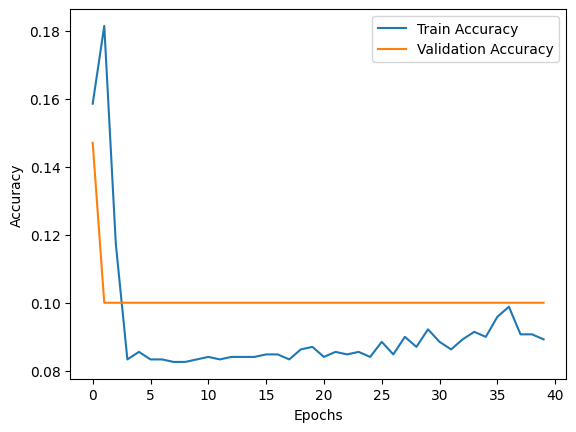

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

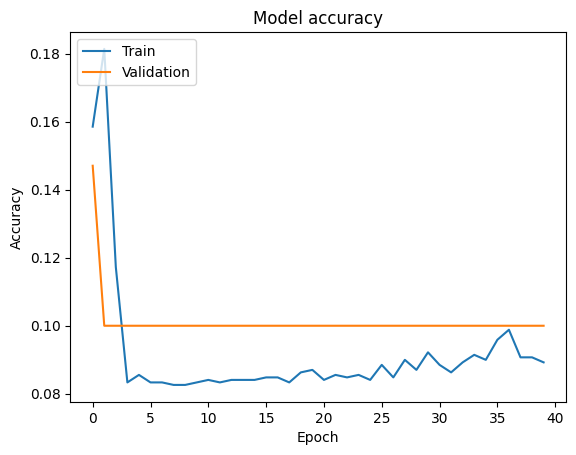

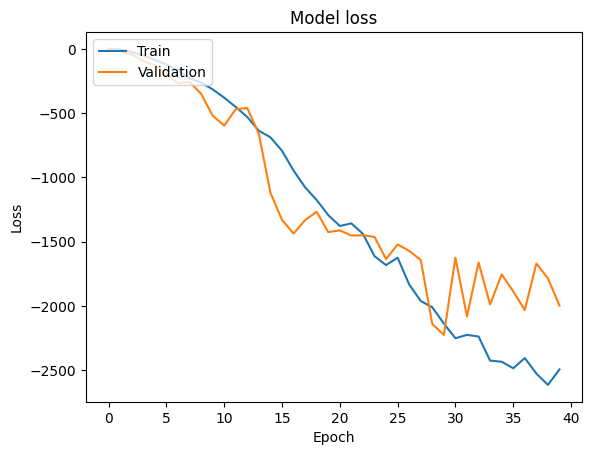

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df_history = pd.DataFrame(history.history)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# Export Data

df_history.to_csv('/content/model_history_efficientnet3.csv', index=True)

In [18]:
from google.colab import files
files.download('/content/model_history_efficientnet3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


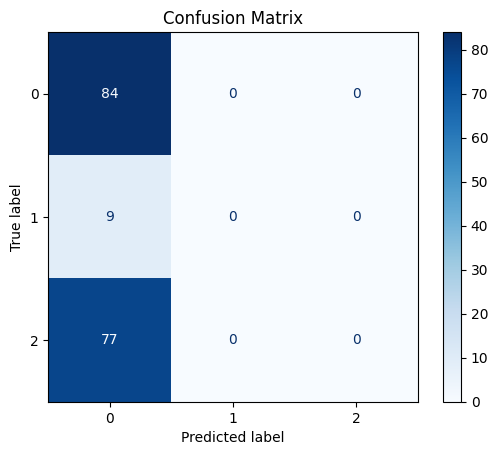

In [19]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

# Get true labels and predicted labels
y_true = []
y_pred = []

# Collect predictions and true labels
for images, labels in ds_test:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(len(cm))],
                     columns=[f"Predicted_{i}" for i in range(len(cm[0]))])

# Save the DataFrame to a CSV file
cm_df.to_csv('/content/confusion_matrix_efficientnet3.csv', index=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from google.colab import files
files.download('/content/confusion_matrix_efficientnet3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Classification Report

import pandas as pd
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

# Generate the classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('/content/classification_report_efficientnet3.csv', index=True)


              precision    recall  f1-score   support

           0       0.49      1.00      0.66        84
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        77

    accuracy                           0.49       170
   macro avg       0.16      0.33      0.22       170
weighted avg       0.24      0.49      0.33       170



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [22]:
from google.colab import files
files.download('/content/classification_report_efficientnet3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>